**Problem statement:**

<b> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.
Importing Skin Cancer Data
Importing all the important libraries </b>


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import glob

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = 'MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration'
#/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Visualize the data

code to visualize one instance of all the nine classes present in the dataset

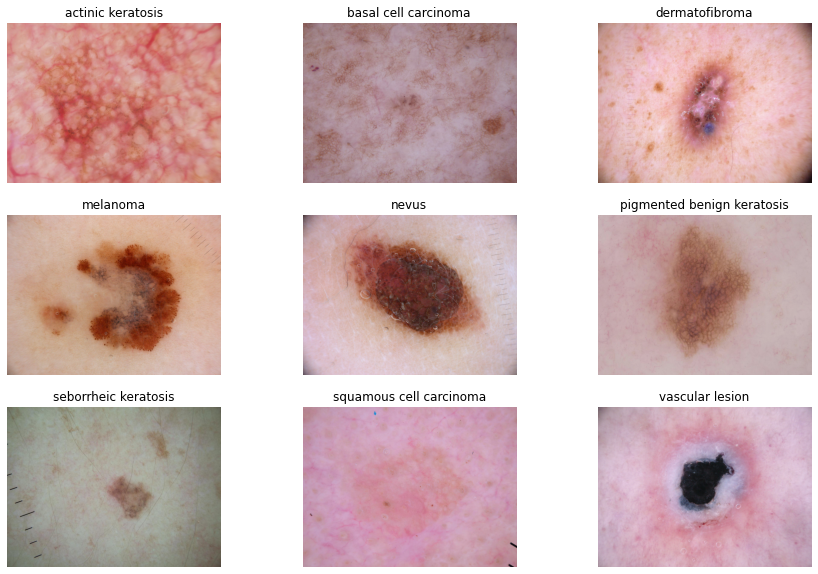

In [ ]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, m_class in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), m_class)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(m_class)
    plt.axis("off")
plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


Check the configuration of gpu and use gpu.

In [ ]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)


[]


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# Using data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)



Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

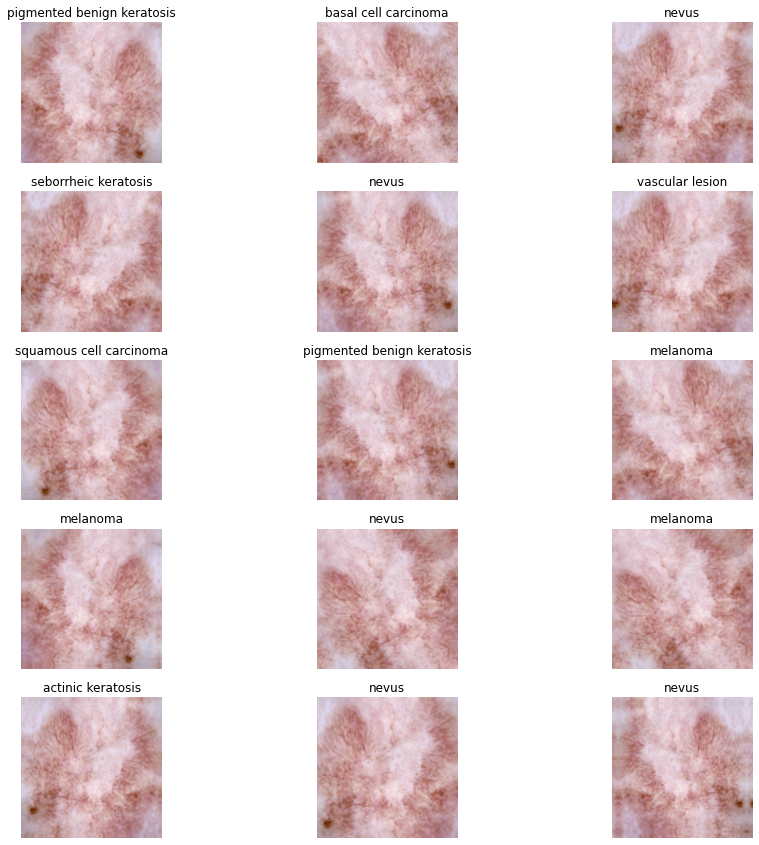

In [ ]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")


Create the model

In [ ]:


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). 
#The RGB channel values are in the [0, 255] range. This is not ideal for a
#neural network. Here, it is good to standardize values to be in the [0, 1]

num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

## Compiling the model

In [ ]:
### We chose adam as optimiser and loss function for our model
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                        

## Training the Model

In [ ]:

epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/20
56/56 [==============================] - 120s 2s/step - loss: 2.0420 - accuracy: 0.2327 - val_loss: 1.9092 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 59s 1s/step - loss: 1.7917 - accuracy: 0.3655 - val_loss: 1.6449 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 59s 1s/step - loss: 1.5318 - accuracy: 0.4626 - val_loss: 1.4879 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 59s 1s/step - loss: 1.4154 - accuracy: 0.5089 - val_loss: 1.4264 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 59s 1s/step - loss: 1.4245 - accuracy: 0.4950 - val_loss: 1.3794 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 59s 1s/step - loss: 1.3207 - accuracy: 0.5363 - val_loss: 1.4067 - val_accuracy: 0.5638
Epoch 7/20
56/56 [==============================] - 60s 1s/step - loss: 1.3028 - accuracy: 0.5391 - val_loss: 1.4658 - val_accuracy: 0.5123
Epoch 8/20
56/56 [=

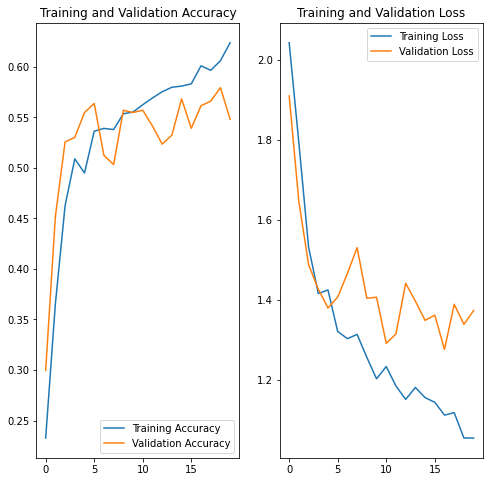

In [ ]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Distribution of classes in the training dataset

### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [ ]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


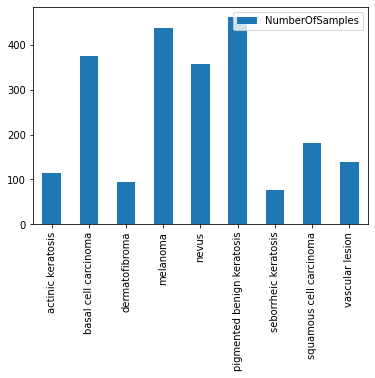

In [ ]:
class_df.plot.bar()
plt.show()

## Rectify the class imbalance

Python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use Augmentor, the following general procedure is followed:

    Instantiate a Pipeline object pointing to a directory containing your initial image data set.
    Define a number of operations to perform on this data set using your Pipeline object.
    Execute these operations by calling the Pipeline’s sample() method.



In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

In [ ]:
path_to_training_dataset = '/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/'+i+'/output/')
    #p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CF08B1450>: 100%|██████████| 1000/1000 [00:56<00:00, 17.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CF085FC50>: 100%|██████████| 1000/1000 [00:57<00:00, 17.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4CEFE70850>: 100%|██████████| 1000/1000 [00:43<00:00, 22.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F4CEFE799D0>: 100%|██████████| 1000/1000 [03:28<00:00,  4.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F4CF08657D0>: 100%|██████████| 1000/1000 [03:23<00:00,  4.92 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CF0858B10>: 100%|██████████| 1000/1000 [00:41<00:00, 23.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4CF2367C90>: 100%|██████████| 1000/1000 [01:36<00:00, 10.37 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CEFF56F50>: 100%|██████████| 1000/1000 [00:42<00:00, 23.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4CF0182290>: 100%|██████████| 1000/1000 [00:41<00:00, 23.92 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:

output_dir = pathlib.Path('/kaggle/working/')


In [ ]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# Train the model on the data created using Augmentor

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
print(output_dir)

/kaggle/working


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:

# Create your model (make sure to include normalization)

num_classes = 9

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [ ]:
#Compile your model (Choose optimizer and loss function appropriately)

model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [ ]:
# Train your model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
225/225 [==============================] - 260s 1s/step - loss: 2.1724 - accuracy: 0.1881 - val_loss: 1.7880 - val_accuracy: 0.3011
Epoch 2/30
225/225 [==============================] - 222s 986ms/step - loss: 1.6723 - accuracy: 0.3496 - val_loss: 1.5427 - val_accuracy: 0.4389
Epoch 3/30
225/225 [==============================] - 221s 984ms/step - loss: 1.3700 - accuracy: 0.4807 - val_loss: 1.2857 - val_accuracy: 0.5394
Epoch 4/30
225/225 [==============================] - 221s 982ms/step - loss: 1.1615 - accuracy: 0.5651 - val_loss: 1.1827 - val_accuracy: 0.5661
Epoch 5/30
225/225 [==============================] - 221s 982ms/step - loss: 0.9971 - accuracy: 0.6378 - val_loss: 1.0258 - val_accuracy: 0.6444
Epoch 6/30
225/225 [==============================] - 221s 982ms/step - loss: 0.8631 - accuracy: 0.6864 - val_loss: 0.9027 - val_accuracy: 0.6906
Epoch 7/30
225/225 [==============================] - 221s 983ms/step - loss: 0.7121 - accuracy: 0.7411 - val_loss: 0.7918 - va

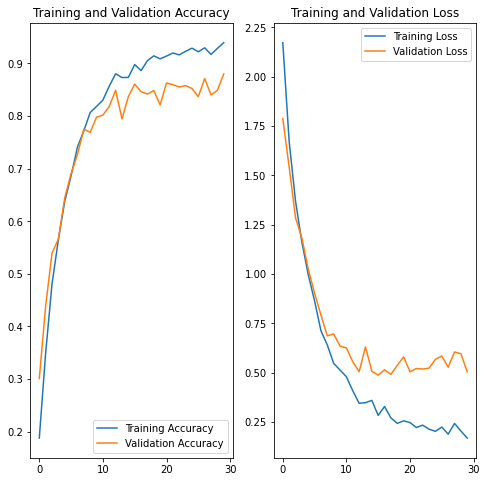

In [ ]:
# Visualize the model result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

We still have a overfitting model but we have much better accuracy than previous models.At end we have around 10% accuuracy difference between training and validation data. Class rebalance helped us in getting better accuracy.

We can reduce the overfitting by having a deeper model or add a data augmentation layer before it.
